In [1]:
import pandas as pd

In [2]:
import numpy as np
import sys
sys.setrecursionlimit(9999)

In [3]:
import glob

In [4]:
csv_list = glob.glob('./HAI 2.0/training/*.csv')

In [5]:
train1 = pd.read_csv(csv_list[0]).rename(columns=lambda x: x.strip())
train2 = pd.read_csv(csv_list[1]).rename(columns=lambda x: x.strip())
train3 = pd.read_csv(csv_list[2]).rename(columns=lambda x: x.strip())


In [6]:
train = pd.concat([train1,train2,train3])
#test = pd.concat([test1, test2])

In [7]:
TAG_MIN = train[['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79']].min()
TAG_MAX = train[['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79']].max()

In [8]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [13]:
train_scaled = normalize(train.drop('time', axis=1))
train_scaled = pd.DataFrame(train_scaled , columns=train.drop('time', axis=1).columns).ewm(alpha=0.9).mean()
train_scaled['time'] = train['time'].tolist()
train_scaled['time']= pd.to_datetime(train_scaled['time'])

In [14]:
from tqdm.notebook import trange
from datetime import timedelta
from tqdm import tqdm

import dateutil

valid_idxs = []
timestamp_list = train_scaled['time'].astype(str).tolist()
WINDOW_SIZE = 90

for L in trange(len(timestamp_list) - WINDOW_SIZE + 1):
    R = L + WINDOW_SIZE - 1
    if dateutil.parser.parse(timestamp_list[R]) - dateutil.parser.parse(timestamp_list[L]) == timedelta(seconds=WINDOW_SIZE - 1):
        valid_idxs.append(L)

In [15]:
tag_values = np.array(train_scaled.drop('time',axis=1), dtype=np.float32)
data_list = []
for q in valid_idxs[:-1] :
    item = {} 
    last = q + WINDOW_SIZE 
    item["given"] = tag_values[q : last]
    item["answer"] = tag_values[last]
    data_list.append(item)

In [16]:
tag_values.shape

(921603, 79)

In [17]:
X_train =  np.array([i['given'] for i in data_list ])
Y_train = np.array([i['answer'] for i in data_list ])

In [18]:
from tensorflow import keras
import tensorflow as tf 

In [19]:
import numpy as np

In [20]:
w = WINDOW_SIZE                # History window (number of time stamps taken into account) 
                         # i.e., filter(kernel) size       
p_w = 1                # Prediction window (number of time stampes required to be 
                         # predicted)
n_features = 79           # Univariate time series

kernel_size = 8          # Size of filter in conv layers
num_filt_1 = 32          # Number of filters in first conv layer
num_filt_2 = 16          # Number of neurons in dense layer
num_nrn_ol = p_w         # Number of neurons in output layer
dropout_rate= 0.2
conv_strides = 1
pool_size_1 = 2          # Length of window of pooling layer 1
pool_size_2 = 2          # Length of window of pooling layer 2
pool_strides_1 = 2       # Stride of window of pooling layer 1
pool_strides_2 = 2       # Stride of window of pooling layer 2

learning_rate = 1e-4  


In [21]:
'''
model = keras.models.Sequential()
model.add(keras.layers.Conv1D(filters=79,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu', input_shape=(w,n_features)))


model.add(keras.layers.MaxPooling1D(pool_size=pool_size_1)) 
                
model.add(keras.layers.Conv1D(filters=79,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

model.add(keras.layers.MaxPooling1D(pool_size=pool_size_2))

model.add(keras.layers.Conv1D(filters=79,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu'))

model.add(keras.layers.MaxPooling1D(pool_size=pool_size_2))


model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=128, activation='relu'))  
model.add(keras.layers.Dense(units=n_features))

model.compile(optimizer='adam', loss='mse')

model.summary()
'''

"\nmodel = keras.models.Sequential()\nmodel.add(keras.layers.Conv1D(filters=79,\n                 kernel_size=kernel_size,\n                 strides=conv_strides,\n                 padding='valid',\n                 activation='relu', input_shape=(w,n_features)))\n\n\nmodel.add(keras.layers.MaxPooling1D(pool_size=pool_size_1)) \n                \nmodel.add(keras.layers.Conv1D(filters=79,\n                 kernel_size=kernel_size,\n                 strides=conv_strides,\n                 padding='valid',\n                 activation='relu'))\n\nmodel.add(keras.layers.MaxPooling1D(pool_size=pool_size_2))\n\nmodel.add(keras.layers.Conv1D(filters=79,\n                 kernel_size=kernel_size,\n                 strides=conv_strides,\n                 padding='valid',\n                 activation='relu'))\n\nmodel.add(keras.layers.MaxPooling1D(pool_size=pool_size_2))\n\n\nmodel.add(keras.layers.Flatten())\n\nmodel.add(keras.layers.Dense(units=128, activation='relu'))  \nmodel.add(keras.layer

In [48]:

inputs = keras.layers.Input(shape=(n_features,w ))
x1 =keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True , input_shape=(n_features,w)))(inputs)
x1 = keras.layers.Bidirectional(keras.layers.LSTM(16,return_sequences=True))(x1)
x2 = keras.layers.Bidirectional(keras.layers.LSTM(8,return_sequences=True))(x1)
x2 = keras.layers.Bidirectional(keras.layers.LSTM(4,return_sequences=True))(x2)
outputs= keras.layers.TimeDistributed(keras.layers.Dense(4))(x2)
outputs= keras.layers.TimeDistributed(keras.layers.Dense(1))(outputs)
model = keras.models.Model(inputs=inputs , outputs= outputs)
model.compile(optimizer='adam', loss='mae')
model.summary()



Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 79, 90)]          0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 79, 64)            31488     
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 79, 32)            10368     
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 79, 16)            2624      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 79, 8)             672       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 79, 4)             36        
_________________________________________________________________
time_distributed_4 (TimeDist (None, 79, 1)             5   

In [19]:
'''
inputs = keras.layers.Input(shape=(w, n_features))
x =keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu', return_sequences=True , input_shape=(w, n_features)))(inputs)
x = keras.layers.LSTM(64,return_sequences=True)(x)

x = keras.layers.Conv1D(filters=num_filt_1,
                 kernel_size=kernel_size,
                 strides=conv_strides,
                 padding='valid',
                 activation='relu')(x)
x= keras.layers.MaxPooling1D()(x)
outputs=keras.layers.TimeDistributed(keras.layers.Dense(n_features))(x)
outputs= keras.layers.Dense(n_features)(outputs)

model = keras.models.Model(inputs=inputs , outputs= outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()
'''

"\ninputs = keras.layers.Input(shape=(w, n_features))\nx =keras.layers.Bidirectional(keras.layers.LSTM(64, activation='relu', return_sequences=True , input_shape=(w, n_features)))(inputs)\nx = keras.layers.LSTM(64,return_sequences=True)(x)\n\nx = keras.layers.Conv1D(filters=num_filt_1,\n                 kernel_size=kernel_size,\n                 strides=conv_strides,\n                 padding='valid',\n                 activation='relu')(x)\nx= keras.layers.MaxPooling1D()(x)\noutputs=keras.layers.TimeDistributed(keras.layers.Dense(n_features))(x)\noutputs= keras.layers.Dense(n_features)(outputs)\n\nmodel = keras.models.Model(inputs=inputs , outputs= outputs)\nmodel.compile(optimizer='adam', loss='mse')\nmodel.summary()\n"

In [49]:
X_train.shape
X_train_reshape = X_train.reshape(len(X_train), 79,90)
Y_train_reshape = Y_train.reshape(len(Y_train), 79 , 1)

In [50]:
import torch

from torch.utils.data import Dataset, DataLoader



In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss' , patience=3)
model_fit = model.fit(X_train_reshape,
                      Y_train_reshape,
                      epochs=20,
                      verbose=1 ,batch_size=1024 , callbacks =[early_stopping])

Epoch 1/20
900/900 [==============================] - 506s 562ms/step - loss: 0.1631
Epoch 2/20
900/900 [==============================] - 531s 590ms/step - loss: 0.0563
Epoch 3/20
900/900 [==============================] - 497s 552ms/step - loss: 0.0392
Epoch 4/20
900/900 [==============================] - 460s 512ms/step - loss: 0.0334
Epoch 5/20
900/900 [==============================] - 403s 448ms/step - loss: 0.0307
Epoch 6/20
900/900 [==============================] - 370s 411ms/step - loss: 0.0288
Epoch 7/20
900/900 [==============================] - 372s 413ms/step - loss: 0.0272
Epoch 8/20
900/900 [==============================] - 370s 411ms/step - loss: 0.0260
Epoch 9/20
900/900 [==============================] - 370s 411ms/step - loss: 0.0250
Epoch 10/20
900/900 [==============================] - 371s 412ms/step - loss: 0.0243
Epoch 11/20
900/900 [==============================] - 370s 411ms/step - loss: 0.0237
Epoch 12/20
900/900 [==============================] - 374s 415

In [72]:
val_csv = pd.read_csv('./HAI 2.0/validation/validation.csv')
test_csv_list = glob.glob('./HAI 2.0/testing/*.csv')

In [73]:
from TaPR_pkg import etapr

In [74]:
test1 = pd.read_csv(test_csv_list[0]).rename(columns=lambda x: x.strip())
test2 = pd.read_csv(test_csv_list[1]).rename(columns=lambda x: x.strip())
test3 = pd.read_csv(test_csv_list[2]).rename(columns=lambda x: x.strip())
test4 = pd.read_csv(test_csv_list[3]).rename(columns=lambda x: x.strip())

test_df = pd.concat([test1,test2,test3,test4])

In [75]:
val_csv.columns

Index(['time', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09',
       'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29',
       'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39',
       'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49',
       'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59',
       'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69',
       'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79',
       'attack'],
      dtype='object')

In [76]:
val_scaled = normalize(val_csv.drop(['time','attack'] , axis=1))
val_scaled = pd.DataFrame(val_scaled , columns=val_csv.drop(['time','attack'], axis=1).columns).ewm(alpha=0.9).mean()
val_scaled['time']= val_csv['time'].tolist()
val_scaled['time']= pd.to_datetime(val_scaled['time'])

In [77]:
valid_idxs_val = []
timestamp_list = val_scaled['time'].astype(str).tolist()

for L in trange(len(timestamp_list) - WINDOW_SIZE + 1):
    R = L + WINDOW_SIZE - 1
    if dateutil.parser.parse(timestamp_list[R]) - dateutil.parser.parse(timestamp_list[L]) == timedelta(seconds=WINDOW_SIZE - 1):
        valid_idxs_val.append(L)

In [78]:
tag_values_val = np.array(val_scaled.drop('time',axis=1), dtype=np.float32)
data_list_val = []
for q in valid_idxs_val[:-1] :
    item = {} 
    last = q + WINDOW_SIZE 
    item["given"] = tag_values_val[q : last]
    item["answer"] = tag_values_val[last]
    data_list_val.append(item)

In [79]:
X_val =  np.array([i['given'] for i in data_list_val ])
Y_val = np.array([i['answer'] for i in data_list_val ])
X_val_reshape = X_val.reshape(len(X_val), 79,90)
Y_val_reshape = Y_val.reshape(len(Y_val), 79 , 1)
Y_hat_val = model.predict(X_val_reshape)
dist = np.abs(Y_val_reshape-Y_hat_val).sum(axis=1)

In [80]:
dist.shape

(43111, 1)

In [81]:
valid_idxs_val = [i+WINDOW_SIZE for i in valid_idxs_val[:-1]]

In [82]:
dist = pd.Series(np.abs(Y_val_reshape-Y_hat_val).sum(axis=1).flatten(), index  = valid_idxs_val)

In [83]:
test_scaled = normalize(test_df.drop('time' , axis=1))
test_scaled = pd.DataFrame(test_scaled , columns=test_df.drop('time', axis=1).columns).ewm(alpha=0.9).mean()
test_scaled['time']= test_df['time'].tolist()
test_scaled['time']= pd.to_datetime(test_scaled['time'])

In [84]:
valid_idxs_test = []
timestamp_list = test_df['time'].astype(str).tolist()

for L in trange(len(timestamp_list) - WINDOW_SIZE + 1):
    R = L + WINDOW_SIZE - 1
    if dateutil.parser.parse(timestamp_list[R]) - dateutil.parser.parse(timestamp_list[L]) == timedelta(seconds=WINDOW_SIZE - 1):
        valid_idxs_test.append(L)

tag_values_test = np.array(test_scaled.drop('time',axis=1), dtype=np.float32)
data_list_test = []
for q in valid_idxs_test[:-1] :
    item = {} 
    last = q + WINDOW_SIZE 
    item["given"] = tag_values_test[q : last]
    item["answer"] = tag_values_test[last]
    data_list_test.append(item)

In [85]:

X_test =  np.array([i['given'] for i in data_list_test ])
Y_test = np.array([i['answer'] for i in data_list_test ])

X_test_reshape = X_test.reshape(len(X_test), 79,90)
Y_test_reshape = Y_test.reshape(len(Y_test), 79 , 1)

#np.savez('X_train_60.npz' , X_train)
#np.savez('Y_train_60.npz' , Y_train)

#np.savez('X_val_60.npz' , X_val)
#np.savez('Y_val_60.npz' , Y_val)

#np.savez('X_test_60.npz' , X_test)
#np.savez('Y_test_60.npz' , Y_test)



In [86]:
test_val= val_csv[['time','attack']]

In [87]:
test_val['dist'] = dist

In [88]:
dist.mean()

2.0521764755249023

In [89]:
test_val = test_val.fillna(0)

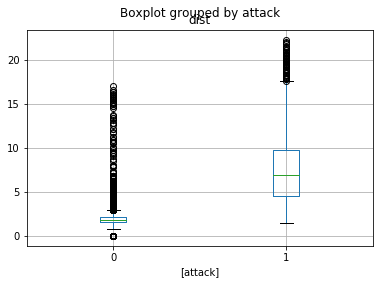

In [90]:
test_val[['attack', 'dist']].boxplot(by= 'attack')

In [94]:
from sklearn.tree import DecisionTreeClassifier

In [95]:
dt = DecisionTreeClassifier()

In [99]:
dt.fit(test_val[['dist']], test_val['attack'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [102]:
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print ("if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print ("} else {")
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print ("}")
                else:
                        print ("return " + str(value[node]))

        recurse(left, right, threshold, features, 0)

In [105]:
get_code(dt, test_val.columns) 

if ( time <= 0.5 ) {
return [[2.8267e+04 1.6000e+01]]
} else {
return [[14305.   613.]]
}


In [98]:
test_val['dist'].shape

(43201,)

In [91]:
test_val.groupby('attack').describe().unstack(1)

             attack
dist  count  0         42572.000000
             1           629.000000
      mean   0             1.957497
             1             8.166656
      std    0             0.626737
             1             5.036685
      min    0             0.000000
             1             1.442848
      25%    0             1.618193
             1             4.510646
      50%    0             1.867514
             1             6.866366
      75%    0             2.163997
             1             9.743896
      max    0            16.999920
             1            22.267738
dtype: float64

In [106]:
threshold = 0.5
test_val['dist'] =test_val['dist'] > thxqeshold
test_val['dist'] = test_val['dist'].astype(int)

In [107]:
TaPR = etapr.evaluate(anomalies=test_val['attack'].tolist(), predictions=test_val['dist'].tolist())
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.025 (TaP: 0.013, TaR: 0.900)
# of detected anomalies: 4
Detected anomalies: ['2', '3', '4', '5']


In [94]:
len(data_list_test)

358447

In [53]:
Y_hat_test = model.predict(X_test)

ValueError: in user code:

    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/wrappers.py:531 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/wrappers.py:645 call
        initial_state=forward_state, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/recurrent.py:654 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:227 assert_input_compatibility
        ', found shape=' + str(shape))

    ValueError: Input 0 is incompatible with layer forward_lstm: expected shape=(None, None, 90), found shape=[None, 90, 79]


In [45]:
Y_hat_test.shape

NameError: name 'Y_hat_test' is not defined

In [46]:
submit = pd.read_csv('./HAI 2.0/sample_submission.csv')

In [47]:
dist = np.abs(Y_test-Y_hat_test).sum(axis=1)
valid_idxs_test = [i+WINDOW_SIZE for i in valid_idxs_test[:-1]]
dist = pd.Series(dist, index  = valid_idxs_test)
attack_simul = dist > threshold
submit['attack'] = attack_simul.fillna(0)
submit['attack']=submit['attack'].fillna(0)
submit["attack"] = submit["attack"].astype(int)

NameError: name 'Y_hat_test' is not defined

In [48]:
submit.index = submit['time']
submit.to_csv('db_f3.csv', index=False)

In [49]:
dist.mean()

1.558778166770935